<a href="https://colab.research.google.com/github/suneetsawant/Bert-Sentence-Similarity/blob/main/IpsoftAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Tensorflow Official Models Api 

In [ ]:
!pip install -q tf-models-official==2.3.0

     |████████████████████████████████| 849kB 11.7MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 174kB 34.8MB/s 
     |████████████████████████████████| 358kB 37.6MB/s 
     |████████████████████████████████| 1.2MB 45.5MB/s 
     |████████████████████████████████| 37.6MB 81kB/s 


## Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

## Get the MRPC sentence pair dataset from tensorflow datasets

In [ ]:
mrpc, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)
list(mrpc.keys())
info.features['label'].names
mrpc_train = mrpc['train']

for key, value in mrpc_train.items():
  print(f"{key:9s}: {value[1].numpy()}")

idx      : 1456
label    : 0
sentence1: b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed ."
sentence2: b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold ."


In [ ]:
bert_dir = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(bert_dir)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Define Bert Tokenizer

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(bert_dir, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

Vocab size: 30522


[101, 102]

In [ ]:
def encode_sentence(sentence, tokenizer):
   tokens = list(tokenizer.tokenize(sentence))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(mrpc, tokenizer):
  num_examples = len(mrpc["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(mrpc["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(mrpc["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
mrpc_train = bert_encode(mrpc['train'], tokenizer)
mrpc_train_labels = mrpc['train']['label']

mrpc_validation = bert_encode(mrpc['validation'], tokenizer)
mrpc_validation_labels = mrpc['validation']['label']

for key, value in mrpc_train.items():
  print(f'{key:15s} shape: {value.shape}')
# mrpc_train
print(f'mrpc_train_labels shape: {mrpc_train_labels.shape}')

total_neg_samples = mrpc_train_labels[mrpc_train_labels==0].shape[0]+mrpc_validation_labels[mrpc_validation_labels==0].shape[0]
total_pos_samples = mrpc_train_labels[mrpc_train_labels==1].shape[0]+mrpc_validation_labels[mrpc_validation_labels==1].shape[0]

total_data_samples = total_neg_samples+total_pos_samples


# normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]

class_weights = {0:1-(total_neg_samples/total_data_samples),
                 1:1-(total_pos_samples/total_data_samples)}
print(f'Number of negative Samples:{total_neg_samples}')
print(f'Number of positive Samples:{total_pos_samples}')
print(f'Number of Total Samples:{total_data_samples}')
class_weights
# mrpc_train_labels.shape
# mrpc_validation_labels.shape


input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
mrpc_train_labels shape: (3668,)
Number of negative Samples:1323
Number of positive Samples:2753
Number of Total Samples:4076


{0: 0.6754170755642788, 1: 0.32458292443572134}

## Configure Bert Classifier Model Parameters

In [ ]:
import json

bert_config_file = os.path.join(bert_dir, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict['hidden_dropout_prob'] = 0.3
config_dict['attention_probs_dropout_prob'] = 0.3
bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'attention_probs_dropout_prob': 0.3,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.3,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
def build_model(max_seq_length,bert_classifier): 
    in_id = tf.keras.layers.Input(shape=(None,), name="input_word_ids")
    in_mask = tf.keras.layers.Input(shape=(None,), name="input_mask")
    in_segment = tf.keras.layers.Input(shape=(None,), name="input_type_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = bert_classifier(bert_inputs)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(bert_output)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    return model



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
bert_classifier (BertClassifier (None, 2)            109483778   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

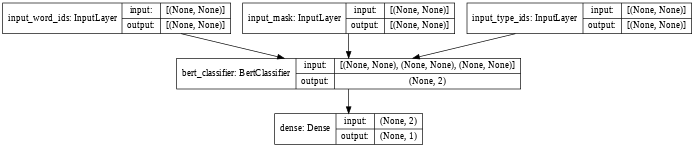

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)
model = build_model(128,bert_classifier)
model.summary()
bert_classifier.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(bert_dir, 'bert_model.ckpt')).assert_consumed()

## Configure Training Parameters

In [ ]:
epochs = 15
batch_size = 32

train_data_size = len(mrpc_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    1e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

## Train the  Model

In [ ]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),]
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_path = "models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=2*steps_per_epoch)

model.save_weights(checkpoint_path.format(epoch=0))

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
    )

model.fit(
      mrpc_train, mrpc_train_labels,
      validation_data=(mrpc_validation, mrpc_validation_labels),
      batch_size=batch_size,
      callbacks=[cp_callback],
      epochs=epochs,
      class_weight=class_weights)


Epoch 1/15
115/115 [==============================] - 63s 403ms/step - loss: 0.3100 - accuracy: 0.4839 - precision: 0.6869 - recall: 0.4379 - auc: 0.5074 - val_loss: 0.6668 - val_accuracy: 0.7010 - val_precision: 0.7199 - val_recall: 0.9211 - val_auc: 0.7212
Epoch 2/15
113/115 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.5545 - precision: 0.7457 - recall: 0.5015 - auc: 0.6071
Epoch 00002: saving model to models/cp-0002.ckpt
115/115 [==============================] - 50s 437ms/step - loss: 0.2979 - accuracy: 0.5559 - precision: 0.7466 - recall: 0.5037 - auc: 0.6084 - val_loss: 0.5566 - val_accuracy: 0.7500 - val_precision: 0.7690 - val_recall: 0.9068 - val_auc: 0.7476
Epoch 3/15
115/115 [==============================] - 44s 385ms/step - loss: 0.2608 - accuracy: 0.6924 - precision: 0.8206 - recall: 0.6832 - auc: 0.7592 - val_loss: 0.5525 - val_accuracy: 0.7255 - val_precision: 0.7136 - val_recall: 1.0000 - val_auc: 0.7918
Epoch 4/15
111/115 [==================

## Inference

In [ ]:
my_examples = bert_encode(
    mrpc = {
        'sentence1':[
            'I am talking about cities.Mumbai is good city',
            'Hello! i am having a great day'],
        'sentence2':[
            'Australia is known for its cricket',
            'Hello! i am having a great day']
    },
    tokenizer=tokenizer)

my_examples
result = model(my_examples, training=False,)
# layer = tf.keras.layers.Softmax()
# layer([-3.0731256,2.4282057]).numpy()
# result = layer(result).numpy()
print(result)
# result = tf.argmax(result).numpy()
# result

tf.Tensor(
[[0.14015727]
 [0.9665628 ]], shape=(2, 1), dtype=float32)


## Export model to saved model format


In [ ]:
tf.saved_model.save(model, 'similarity_model/')
!ls similarity_model/


INFO:tensorflow:Assets written to: similarity_model/assets


INFO:tensorflow:Assets written to: similarity_model/assets


assets	saved_model.pb	variables


## Install pydirve to upload models to drive

In [ ]:
!pip install -U -q PyDrive
!pip install httplib2==0.15.0
# 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
class Drive():   
  def __init__(self) :  
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)


  def fileaction(self,files,op='up') : 
    file_list = self.drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for filename in files:
      flag = 0 

      for file1 in file_list:
        if (file1['title']) == filename :
            if (op == 'up'and flag==0) : 
                file1.Delete()
                self.upload(filename)
                flag = 1

            elif (op == 'down') : 
                self.download(filename,file1) 

      if(op=='up' and flag==0): 
            self.upload(filename)
            flag = 1

  def upload(self,filename) : 
      Uploadfile = self.drive.CreateFile({'title': filename})
      Uploadfile.SetContentFile(filename)
      Uploadfile.Upload()
      print("Saved '{}' to Drive".format(filename))

  def download(self,filename,file1): 
      downloaded = self.drive.CreateFile({'id':file1['id']})
      downloaded.GetContentFile(filename)
      print("Downloaded '{}' from Drive".format(filename))


  Using cached https://files.pythonhosted.org/packages/be/83/5e006e25403871ffbbf587c7aa4650158c947d46e89f2d50dcaf018464de/httplib2-0.15.0-py3-none-any.whl
ERROR: google-api-python-client 1.7.12 has requirement httplib2<1dev,>=0.17.0, but you'll have httplib2 0.15.0 which is incompatible.
  Found existing installation: httplib2 0.18.1
    Uninstalling httplib2-0.18.1:
      Successfully uninstalled httplib2-0.18.1


In [ ]:
!zip -r similarity_model.zip similarity_model/
Drive().fileaction(['similarity_model.zip'],'up')


updating: similarity_model/ (stored 0%)
updating: similarity_model/variables/ (stored 0%)
updating: similarity_model/variables/variables.index (deflated 80%)
updating: similarity_model/variables/variables.data-00000-of-00001 (deflated 16%)
updating: similarity_model/saved_model.pb (deflated 93%)
updating: similarity_model/assets/ (stored 0%)
Saved 'similarity_model.zip' to Drive
